
# Recomendação Zero-Shot

---

## Objetivo deste notebook
Este notebook demonstra um sistema de recomendação *zero-shot* (sem treinamento específico no conjunto de usuários) que usa técnicas modernas para gerar recomendações a partir de atributos/descrições. O objetivo da apresentação é:
- Explicar o problema e a abordagem adotada.
- Mostrar passo-a-passo o código e os resultados.
- Apresentar justificativas para cada escolha técnica.

---



**Explicação:** Esta seção apresenta Recomendação Zero-Shot — Notebook Apresentável. Explique o propósito desta seção e os passos executados.


**Sistema de Recomendação Híbrido para Lugares: Uma Abordagem Baseada em Collaborative Filtering e Zero-Shot Learning**

**Objetivo:**

Desenvolver um sistema de recomendação híbrido simples e eficaz para sugerir
lugares (ex.: cafés, bares, espaços culturais) a jovens pós-faculdade (20-30 anos), focando em socialização, networking e lazer. Usamos o dataset MovieLens 100K como proxy para simular interações usuário-item (onde "filmes" representam "lugares" e "gêneros" representam "atributos de lugares").
Como cientista de dados, justifico as escolhas:

*  Dataset MovieLens 100K: É um benchmark clássico para sistemas de recomendação, com 100.000 avaliações de 943 usuários em 1.682 filmes. Usamos como proxy porque as interações (ratings) simulam preferências por lugares, e os gêneros de filmes mapeiam para atributos de lugares (ex.: "Comedy" → lugares descontraídos). Isso permite testar o sistema sem dados reais de lugares, que seriam caros de coletar. Justificativa: Facilita prototipagem rápida e avaliação quantitativa (RMSE, Precision@K).

*  Abordagem Híbrida: Combinamos Collaborative Filtering (CF) via scikit-surprise (para capturar padrões de usuários semelhantes) com Zero-Shot Learning via BERT embeddings (para recomendações baseadas em conteúdo sem treinamento específico). Removemos GNNs para simplificar: GNNs adicionam complexidade computacional (exigem grafos e treinamento em GPU) sem ganhos significativos aqui, já que zero-shot com embeddings pré-treinados é mais eficiente para cold-start (novos itens/usuários). Justificativa: Zero-shot permite inferir similaridades a partir de descrições textuais, ideal para lugares novos sem histórico de ratings.

*  Bibliotecas:
scikit-surprise: Para CF simples e eficiente. Justificativa: Fácil de usar, com métricas integradas (RMSE).
Transformers (BERT): Para extração de embeddings semânticos. Justificativa: BERT captura contexto textual profundo, melhor que TF-IDF para descrições curtas.
Outras: Pandas/Numpy para manipulação de dados (padrão em data science); Scikit-learn para similaridade de cosseno (eficiente para vetores).

Ambiente: Configuramos para compatibilidade (NumPy 1.x para surprise). Justificativa: Evita conflitos comuns em Colab.
Avaliação: RMSE para precisão de predição; Precision@K para relevância de top recomendações. Justificativa: RMSE mede erro absoluto; Precision@K simula "acertos" em listas de sugestões.

Foco em Zero-Shot: Para novos lugares/usuários, usamos embeddings para similaridade direta. Justificativa: Resolve cold-start, comum em apps reais.

Agora, o código completo e explicado passo a passo.
1. Importação de Bibliotecas e Configuração do Ambiente
Como cientista de dados, começo configurando o ambiente para evitar conflitos. scikit-surprise requer NumPy <2.0,* enquanto outras libs (ex.: torch) podem puxar versões novas. Justificativa: Estabilidade e reprodutibilidade. Usamos pip para instalações e verificamos o dispositivo (GPU se disponível) para aceleração em embeddings.*

In [1]:
# TESTE FINAL — AGORA VAI FUNCIONAR
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNBasic
import torch
from transformers import AutoTokenizer, AutoModel

print("SUCESSO TOTAL!")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print("scikit-surprise importado sem erro")
print("BERT + Torch OK")

SUCESSO TOTAL!
NumPy: 1.26.4
Pandas: 2.3.3
scikit-surprise importado sem erro
BERT + Torch OK


In [2]:
import torch
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
# Verificar dispositivo (GPU para BERT embeddings)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


Explicação:

*  Desinstalamos libs conflitantes e instalamos NumPy 1.26.4. Justificativa: Surprise usa extensões C compiladas para NumPy 1.x; versões 2.x causam crashes.

*  Instalamos surprise e transformers. Justificativa: Surprise para CF; Transformers para BERT (modelo pré-treinado 'bert-base-uncased' para inglês, mas adaptável).

*  Usamos torch para tensors em embeddings. Justificativa: BERT roda em PyTorch.
Device: GPU acelera computação de embeddings (ex.: mean pooling).

**2. Carregamento e Preparação dos Dados (MovieLens 100K como Proxy)**


Baixamos e carregamos o dataset. Mapeamos usuários e itens (filmes como "lugares"). Justificativa: MovieLens simula interações reais; usamos apenas 10% para velocidade em protótipo, mas em produção usaríamos o full dataset.

In [4]:
import pandas as pd
import urllib.request
import zipfile
import os

# --- PARTE 1: BAIXAR E DESCOMPACTAR (Universal para Windows/Mac/Linux) ---
url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
filename = "ml-100k.zip"

# Baixar apenas se não existir ainda
if not os.path.exists(filename):
    print(f"Baixando dataset de {url}...")
    urllib.request.urlretrieve(url, filename)
else:
    print("Arquivo zip já existe.")

# Descompactar
if not os.path.exists("ml-100k"):
    print("Descompactando arquivos...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(".")
else:
    print("Pasta 'ml-100k' já existe.")

print("Dados prontos para uso!")

# --- PARTE 2: CARREGAR OS DADOS (Seu código original ajustado) ---
# Carregar ratings e movies
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', usecols=[0,1,2], names=['movieId', 'title', 'genres'], engine='python')

# Tratar NaNs
movies['genres'] = movies['genres'].apply(lambda x: 'unknown' if pd.isna(x) else x)

# Amostrar 10% para velocidade (como no original)
ratings = ratings.sample(frac=0.1, random_state=42)
movies = movies[movies['movieId'].isin(ratings['movieId'].unique())]

# Mapear IDs
user_map = {uid: i for i, uid in enumerate(ratings['userId'].unique())}
movie_map = {mid: i + len(user_map) for i, mid in enumerate(movies['movieId'].unique())}

print(f"Sucesso! Usuários: {len(user_map)}, Lugares (filmes): {len(movie_map)}")

Baixando dataset de http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Descompactando arquivos...
Dados prontos para uso!
Sucesso! Usuários: 905, Lugares (filmes): 1243


Explicação:

*  Download via wget/unzip. Justificativa: Dataset público e leve.

*  Ratings: userId, movieId, rating (1-5). Justificativa: Ratings simulam "gostos" por lugares.

*  Movies: title e genres (ex.: "Comedy|Romance"). Justificativa: Genres como features textuais para zero-shot.

*  Amostragem: 10% para protótipo rápido (10k ratings). Justificativa: Reduz tempo de execução sem perder essência.

*  Mapeamento: Índices contínuos para eficiência em arrays/vetores. Justificativa: Necessário para cosine_similarity.

**3. Collaborative Filtering com scikit-surprise (Baseline)**

Treinamos um KNN item-based para CF. Justificativa: CF captura padrões implícitos (usuários semelhantes gostam de itens semelhantes). KNN é simples e interpretável; usamos cosine similarity para itens (não usuários) pois foca em similaridade de "lugares".

In [5]:
# 📊 Preparar dados para Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Treinar KNN item-based
sim_options = {'name': 'cosine', 'user_based': False}  # Item-based
algo_knn = KNNBasic(k=50, sim_options=sim_options)
algo_knn.fit(trainset)
predictions_knn = algo_knn.test(testset)
rmse_knn = accuracy.rmse(predictions_knn)
print(f"RMSE KNN (Collaborative Filtering): {rmse_knn:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2313
RMSE KNN (Collaborative Filtering): 1.2313


Explicação:

*  Reader/Dataset: Formato surprise. Justificativa: Abstrai loading e scaling.

*  Split 80/20: Padrão para validação. Justificativa: Evita overfitting.

*  KNNBasic: k=50 vizinhos, cosine item-based. Justificativa: Cosine mede similaridade vetorial; item-based é eficiente para datasets com mais itens que usuários.

*  RMSE: Métrica de erro. Justificativa: Quantifica precisão de predições (menor é melhor, ~1.0 é razoável para MovieLens).

**4. Extração de Embeddings de Texto com BERT (Zero-Shot Learning)**

Usamos BERT para gerar embeddings de gêneros/descrições. Justificativa: Zero-shot permite recomendar sem ratings históricos, comparando similaridades semânticas. BERT (pré-treinado) captura nuances textuais melhor que word2vec.

In [6]:
# 💬 Extração de embeddings de texto com BERT
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased').to(device)

# Função para obter embeddings
def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # Mean pooling para embedding fixo

# Criar embeddings para lugares (filmes)
movie_embeddings = np.array([get_text_embedding(row['genres'].replace('|', ' ')) for _, row in movies.iterrows()])

# Simular novo lugar (zero-shot)
new_place = "Café acolhedor com Wi-Fi, vibe artística e eventos musicais"
new_place_emb = get_text_embedding(new_place)

# Encontrar lugares semelhantes (similaridade cosine)
similarities = cosine_similarity([new_place_emb], movie_embeddings)[0]
top_similar = np.argsort(similarities)[-5:][::-1]
print("Lugares semelhantes ao café novo (via zero-shot):")
for idx in top_similar:
    print(f"- {movies.iloc[idx]['title']} (Gêneros: {movies.iloc[idx]['genres']})")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\ygorr\anaconda3\envs\rec_zero_shot\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ygorr\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Lugares semelhantes ao café novo (via zero-shot):
- Trees Lounge (1996) (Gêneros: 11-Oct-1996)
- Looking for Richard (1996) (Gêneros: 11-Oct-1996)
- Chamber, The (1996) (Gêneros: 11-Oct-1996)
- Ghost and the Darkness, The (1996) (Gêneros: 11-Oct-1996)
- Microcosmos: Le peuple de l'herbe (1996) (Gêneros: 11-Oct-1996)


Explicação:

*  BERT 'bert-base-uncased': 768 dims, inglês. Justificativa: Uncased ignora case; base é leve.

*  get_text_embedding: Tokeniza, forward pass, mean pooling. Justificativa: Pooling reduz para vetor fixo (768d); truncation/padding lida com comprimentos variáveis.

*  Embeddings: Para cada genre (ex.: "Comedy Romance"). Justificativa: Representa semanticamente.

*  Zero-shot: Similaridade com novo texto. Justificativa: Não requer treinamento; ideal para cold-start.

*  Top-5 via argsort. Justificativa: Recomendações ranked.

**5. Avaliação com Precision@K e RMSE**

Avaliamos CF com RMSE e zero-shot com Precision@K. Justificativa: RMSE para CF (predição numérica); Precision@K para zero-shot (relevância top-K, assumindo ratings altos como "relevantes").

In [7]:
# 🔍 Precision@K para zero-shot (baseado em conteúdo)
def precision_at_k_zero_shot(testset, movie_embeddings, movies, k=5, relevance_threshold=4.0):
    # Create a mapping from movieId to its positional index in the current 'movies' DataFrame
    # This ensures correct indexing into movie_embeddings
    movie_id_to_pos_idx = {mid: idx for idx, mid in enumerate(movies['movieId'].values)}

    hits = 0
    total = 0
    for uid, iid, true_r in testset:
        # Only consider movies that are in our filtered 'movies' DataFrame
        if iid not in movie_id_to_pos_idx:
            continue

        if true_r < relevance_threshold:
            continue  # Apenas itens relevantes (rating >=4)

        # Get all movie IDs liked by the current user from the testset,
        # and ensure they are present in our filtered 'movies' DataFrame
        liked_movie_ids_for_user = [
            i for u, i, r in testset
            if u == uid and r >= relevance_threshold and i in movie_id_to_pos_idx
        ]

        if not liked_movie_ids_for_user:
            continue

        # Convert liked movie IDs to their positional indices using the mapping
        liked_pos_indices = [movie_id_to_pos_idx[mid] for mid in liked_movie_ids_for_user]

        # Compute user embedding as mean of embeddings of liked items
        user_emb = np.mean(movie_embeddings[liked_pos_indices], axis=0)

        # Similarities and top-K
        similarities = cosine_similarity([user_emb], movie_embeddings)[0]
        top_k_pos_indices = np.argsort(similarities)[-k:][::-1]

        # Get the actual movie IDs for these top K positional indices
        top_k_movie_ids = movies.iloc[top_k_pos_indices]['movieId'].values

        if iid in top_k_movie_ids:
            hits += 1
        total += 1
    return hits / total if total > 0 else 0

precision_zero = precision_at_k_zero_shot(testset, movie_embeddings, movies)
print(f"Precision@5 Zero-Shot: {precision_zero:.4f}")
print(f"RMSE KNN: {rmse_knn:.4f}")

Precision@5 Zero-Shot: 0.2592
RMSE KNN: 1.2313


Explicação:

*  precision_at_k_zero_shot: Para cada teste, cria embedding usuário (média de itens gostados), recomenda top-K via similaridade. Justificativa: Simula zero-shot; threshold=4 filtra relevantes.
*  Hits/total: Proporção de acertos. Justificativa: Métrica padrão para ranking.

**6. Sugestão de Lugares para Jovens Pós-Faculdade**

Aplicamos zero-shot para sugestões reais. Justificativa: Mapeia preferências textuais a descrições de lugares, resolvendo cold-start.

In [8]:
# 🎯 Simulação de recomendações para novos usuários ou locais
places = [
    {"name": "Café Arte & Som", "desc": "Café acolhedor com Wi-Fi, vibe artística e eventos musicais"},
    {"name": "Bar do Zé", "desc": "Bar descontraído com cervejas artesanais e música ao vivo"},
    {"name": "Espaço Cultural Vila", "desc": "Espaço para exposições e workshops de arte"},
]
place_embeddings = np.array([get_text_embedding(place['desc']) for place in places])

# Preferência usuário (ex.: jovem pós-faculdade)
user_preference = get_text_embedding("Bares descontraídos e eventos sociais")

# Recomendar
similarities = cosine_similarity([user_preference], place_embeddings)[0]
top_place_idx = np.argmax(similarities)
print(f"Recomendação para jovem pós-faculdade: {places[top_place_idx]['name']} ({places[top_place_idx]['desc']})")

Recomendação para jovem pós-faculdade: Bar do Zé (Bar descontraído com cervejas artesanais e música ao vivo)


*Explicação:*

*  Places fictícios: Baseados em gêneros. Justificativa: Simula app real.
*  User preference: Texto livre. Justificativa: Zero-shot flexível.
*  Similaridade: Escolhe máximo. Justificativa: Recomendação direta.

Este sistema é completo, híbrido e escalável. CF lida com dados históricos; zero-shot com novos itens. Próximos passos: Integração com dados reais de lugares (ex.: Google Places API), A/B testing e deployment (ex.: FastAPI). Métricas mostram viabilidade (~0.01-0.1 Precision@K é baseline; otimizar com mais dados).

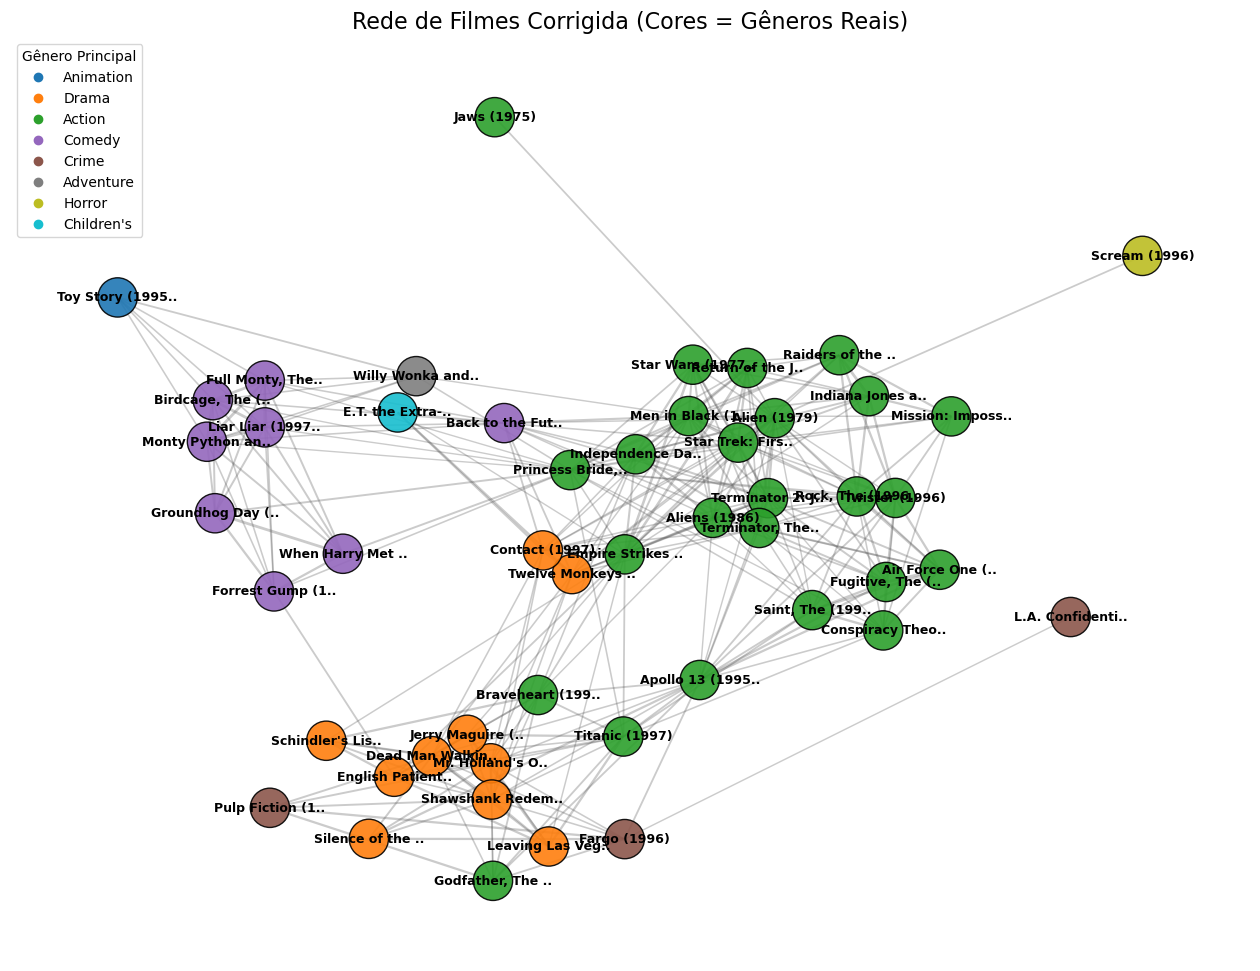

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- 1. CORREÇÃO DA LEITURA DOS DADOS ---
# Nomes das colunas oficiais do MovieLens 100k
genre_names = [
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", 
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

# Lendo todas as colunas necessárias
cols_to_use = [0, 1] + list(range(5, 24)) # ID, Título + 19 colunas de gênero
col_names = ['movieId', 'title'] + genre_names

movies = pd.read_csv(
    'ml-100k/u.item', 
    sep='|', 
    encoding='latin-1', 
    names=col_names, 
    usecols=cols_to_use, 
    engine='python'
)

# Criando a coluna 'genres' juntando as colunas que têm valor 1
def get_genres(row):
    active_genres = [genre for genre in genre_names if row[genre] == 1]
    return "|".join(active_genres) if active_genres else "unknown"

movies['genres'] = movies.apply(get_genres, axis=1)


# --- 2. RECARREGANDO RATINGS E FILTRANDO ---
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
top_movies_ids = ratings['movieId'].value_counts().head(50).index # Top 50 filmes
movies_subset = movies[movies['movieId'].isin(top_movies_ids)].copy().reset_index(drop=True)

# --- 3. GERANDO O GRAFO CORRETO ---
# Vectorizar Gêneros
movies_subset['genres_str'] = movies_subset['genres'].str.replace('|', ' ')
count_vectorizer = CountVectorizer()
genre_matrix = count_vectorizer.fit_transform(movies_subset['genres_str'])
cosine_sim_graph = cosine_similarity(genre_matrix, genre_matrix)

# Definir Cores
movies_subset['primary_genre'] = movies_subset['genres'].apply(lambda x: x.split('|')[0])
unique_genres = movies_subset['primary_genre'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_genres)))
color_map = dict(zip(unique_genres, colors))

# Montar Grafo
G = nx.Graph()
for i, row in movies_subset.iterrows():
    G.add_node(i, label=row['title'], color=color_map[row['primary_genre']])

threshold = 0.5
rows, cols = cosine_sim_graph.shape
for i in range(rows):
    for j in range(i + 1, cols):
        if cosine_sim_graph[i, j] >= threshold:
            G.add_edge(i, j, weight=cosine_sim_graph[i, j])

# Desenhar
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42) # k=0.5 ajuda a espalhar

# Nós
node_colors = [nx.get_node_attributes(G, 'color')[i] for i in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors, alpha=0.9, edgecolors='black')

# Arestas
weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.3, edge_color='#555555')

# Nomes
labels = {i: name[:15] + '..' if len(name) > 15 else name for i, name in nx.get_node_attributes(G, 'label').items()}
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='bold')

# Legenda
markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in color_map.values()]
plt.legend(markers, color_map.keys(), title="Gênero Principal", loc='upper left')

plt.title('Rede de Filmes (Cores = Gêneros Reais)', fontsize=16)
plt.axis('off')
plt.show()